In [1]:
from rex import WindX
from albatross.requests import get_regions, request_wtk_point_data, build_wtk_filepath, identify_regions
from albatross.analysis import boxplot, plot_windrose
import pandas as pd

In [2]:
DATASETS = ['coordinates', 'inversemoninobukhovlength_2m', 'meta', 'precipitationrate_0m', 'pressure_0m', 'pressure_100m', 'pressure_200m', 'relativehumidity_2m', 'temperature_100m', 'temperature_10m', 'temperature_120m', 'temperature_140m', 'temperature_160m', 'temperature_200m', 'temperature_2m', 'temperature_40m', 'temperature_60m', 'temperature_80m', 'time_index', 'winddirection_100m', 'winddirection_10m', 'winddirection_120m', 'winddirection_140m', 'winddirection_160m', 'winddirection_200m', 'winddirection_40m', 'winddirection_60m', 'winddirection_80m', 'windspeed_100m', 'windspeed_10m', 'windspeed_120m', 'windspeed_140m', 'windspeed_160m', 'windspeed_200m', 'windspeed_40m', 'windspeed_60m', 'windspeed_80m']

In [3]:
get_regions(True)

{
    "bangladesh": {
        "year_range": [
            2014,
            2017
        ],
        "resolutions": [
            "hourly"
        ],
        "lat_lon_range": [
            [
                20.63102,
                28.500214
            ],
            [
                85.809204,
                93.72342
            ]
        ]
    },
    "canada": {
        "year_range": [
            2007,
            2014
        ],
        "resolutions": [
            "hourly",
            "5min"
        ],
        "lat_lon_range": [
            [
                40.0522,
                68.10168
            ],
            [
                -144.3318,
                -40.799896
            ]
        ]
    },
    "central_asia": {
        "year_range": [
            2015,
            2015
        ],
        "resolutions": [
            "hourly"
        ],
        "lat_lon_range": [
            [
                35.184048,
                55.425625
            ],
            [
      

{'bangladesh': {'year_range': [2014, 2017],
  'resolutions': ['hourly'],
  'lat_lon_range': [[20.63102, 28.500214], [85.809204, 93.72342]]},
 'canada': {'year_range': [2007, 2014],
  'resolutions': ['hourly', '5min'],
  'lat_lon_range': [[40.0522, 68.10168], [-144.3318, -40.799896]]},
 'central_asia': {'year_range': [2015, 2015],
  'resolutions': ['hourly'],
  'lat_lon_range': [[35.184048, 55.425625], [46.519226, 87.2984]]},
 'conus': {'year_range': [2007, 2014],
  'resolutions': ['hourly', '5min'],
  'lat_lon_range': [[23.833504, 49.3556], [-129.22923, -65.7146]]},
 'hawaii': {'year_range': [2000, 2019],
  'resolutions': ['hourly', '5min'],
  'base': 'Hawaii',
  'lat_lon_range': [[15.564247, 26.22171], [-164.45187, -151.27744]]},
 'india': {'year_range': [2014, 2014],
  'resolutions': ['hourly'],
  'lat_lon_range': [[4.2723618, 31.015549], [63.305073, 92.87215]]},
 'mexico': {'year_range': [2007, 2014],
  'resolutions': ['hourly', '5min'],
  'lat_lon_range': [[8.510117, 32.714092], [-

In [4]:
lat_lon = (44.25, -124.56)

In [5]:
identify_regions(lat_lon)

['canada', 'conus', 'nw_pacific']

In [6]:
identify_regions(lat_lon, coordinates=True)

[{'canada': array([[  48.45922 , -130.72037 ],
         [  48.47494 , -130.73332 ],
         [  48.490665, -130.74628 ],
         ...,
         [  45.943645,  -54.28833 ],
         [  45.95981 ,  -54.274994],
         [  45.97596 ,  -54.261658]], dtype=float32)},
 {'conus': array([[  37.603382, -127.61705 ],
         [  37.62042 , -127.62601 ],
         [  37.63745 , -127.63498 ],
         ...,
         [  40.369072,  -65.73694 ],
         [  40.386314,  -65.727936],
         [  40.403545,  -65.71893 ]], dtype=float32)},
 {'nw_pacific': array([[  47.28825 , -130.60022 ],
         [  47.306824, -130.60214 ],
         [  47.325405, -130.60406 ],
         ...,
         [  49.49722 , -121.6743  ],
         [  49.51579 , -121.67311 ],
         [  49.53436 , -121.67192 ]], dtype=float32)}]

In [7]:
year = 2007
params = ['windspeed_10m', 'winddirection_10m']
(data, meta) = request_wtk_point_data(lat_lon, year, params, region='nw_pacific', resolution="5min")

In [8]:
data

,windspeed_10m,winddirection_10m
time_index,,
2007-01-01 00:00:00+00:00,3.31,211.770004
2007-01-01 00:05:00+00:00,3.27,215.139999
2007-01-01 00:10:00+00:00,3.40,218.080002
2007-01-01 00:15:00+00:00,3.38,223.460007
2007-01-01 00:20:00+00:00,3.27,224.000000
...,...,...
2007-12-31 23:35:00+00:00,8.57,103.269997
2007-12-31 23:40:00+00:00,8.60,104.099998
2007-12-31 23:45:00+00:00,8.60,104.949997


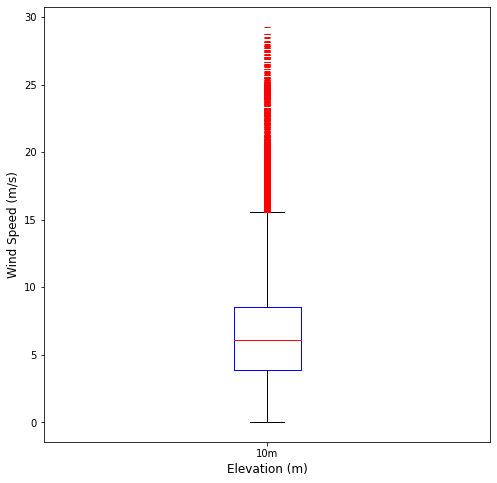

In [9]:
fig, ax = boxplot(data)
fig.set_figheight(8)
fig.set_figwidth(8)

<WindroseAxes:>

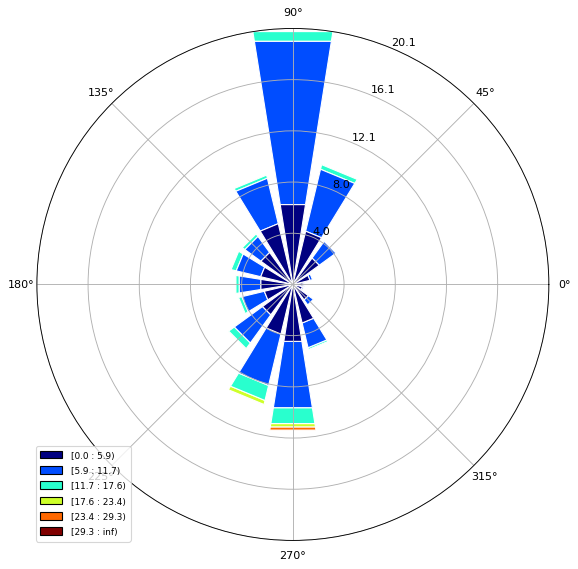

In [10]:
plot_windrose(data)